#### Case 2: Isobaric evaporation of liquid nitrogen in a 6.75 L vertically orientated cylindrical tank experiments.

This notebook sets up the isobaric evaporation of liquid nitrogen ($LN_2$) in a 6.75 L storage tank. A low liquid filling, low heat ingress scenario from Seo and Jeong (2009) is considered. This tank is representative of lab-scale tanks used for cryogen evaporation experiments that measure boil-off rates and thermal stratification.

In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Setup tank and cryogen properties

In [2]:
# LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 0.201 # Internal diameter / m
d_o = 0.204   # External diameter / m
T_air = 298.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.026 # W/m2/K
U_V = 0.026 # W/m2/K

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, 

# Vertically orientated cylindrical tank volume
V_tank = 6.75e-3 #m^3

# Initial liquid filling / Dimensionless
LF = 0.278 

# Specify tank operating pressure
P = 100000 # Pa

# Initialize large-scale tank
small_tank = Tank(d_i, d_o, V_tank, LF)
small_tank.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.963)

# Initialise cryogen
nitrogen = Cryogen(name = "nitrogen")
nitrogen.set_coolprops(P)

# Set cryogen
small_tank.cryogen = nitrogen

# Calculate initial evaporation rate
print("The initial evaporation rate of " + nitrogen.name + " is %.1e kg/h" % (small_tank.b_l_dot * 3600))

The initial evaporation rate of nitrogen is 1.4e-02 kg/h


Calculate initial evaporation rate and transient period

In [3]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + nitrogen.name + " is %.1e kg/h" % (small_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % small_tank.tau)

# Minimum number of hours to achieve steady state 
tau_min = (np.floor(small_tank.tau / 60) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i min" % tau_min)

# Calculate boil-off rate
BOR = (small_tank.b_l_dot * 24 * 3600) / (small_tank.V * small_tank.LF * small_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of nitrogen is 1.4e-02 kg/h
Transient period = 5807.599 s 
Simulation time: 97 min
BOR = 21.827 %


In [4]:
small_tank.tau 

5807.598802272411

#### Simulation setup and execution

In [5]:
# Define vertical spacing
dz = 0.005

# Calculate number of nodes
n_z = 1 + int(np.round(small_tank.l_V/dz, 0))

# Define dimensionless computational grid
small_tank.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
small_tank.U_roof = 0

# Define evaporation time as twice as the transient period
evap_time = 60 * tau_min * 2

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
small_tank.time_interval = 60

# Time step to plot each vapour temperature profile
small_tank.plot_interval = evap_time/6

# Simulate the evaporation
small_tank.evaporate(evap_time)

#### Visualisation of results

#### Vapour temperature

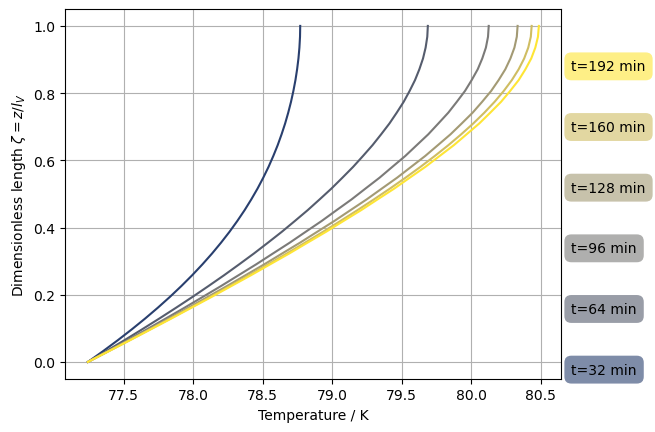

In [6]:
# Visualise the plot
small_tank.plot_tv(t_unit = 'min')

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

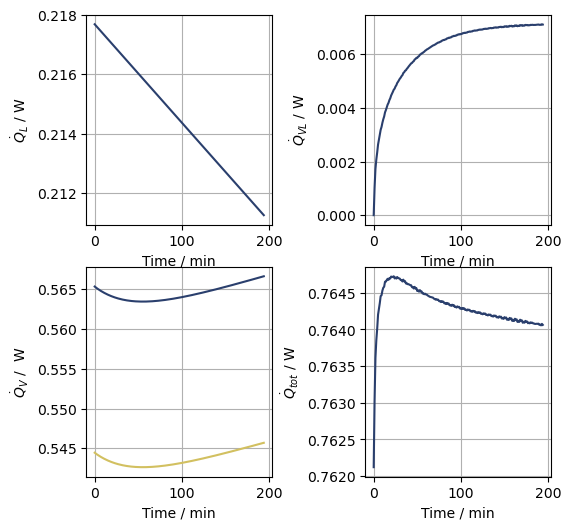

In [7]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank.plot_Q(unit="W", t_unit = 'min')

#### Plot liquid volume

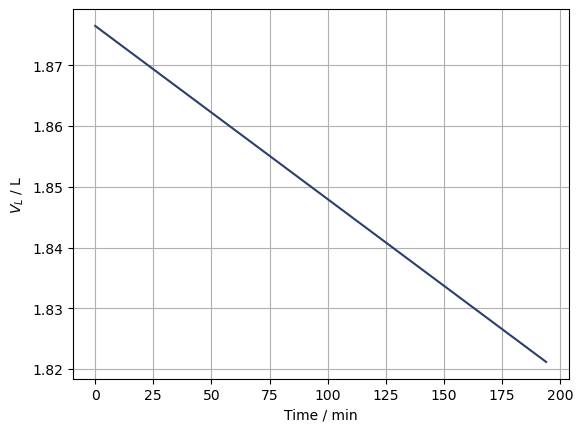

In [8]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank.plot_V_L(unit="L", t_unit = 'min')

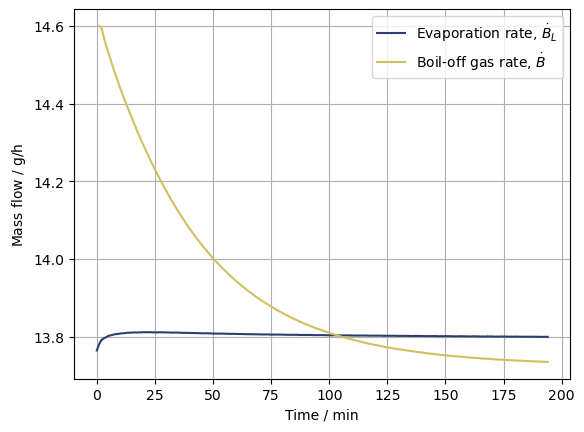

In [9]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank.plot_BOG(unit='g/h', t_unit = 'min')

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [10]:
# Import pandas 
import pandas as pd

In [11]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(small_tank.data)

# Save file to the current working directory
df_evap.to_csv('LN2_small_m3.csv')

# Show the first five columns of the dataframe in console
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,Q_Vw,Q_tot
0,0.0,77.243500,4.556335,0.000000,0.217685,0.565355,0.001877,0.000004,0.000004,0.000000,0.000000e+00,0.544436,0.762121
1,60.0,77.291318,4.553270,0.001021,0.217652,0.565265,0.001876,0.000004,0.000004,-0.000051,-4.747075e-09,0.544350,0.763023
2,120.0,77.337049,4.550205,0.001723,0.217619,0.565181,0.001876,0.000004,0.000004,-0.000050,-4.749642e-09,0.544269,0.763611
3,180.0,77.381267,4.547246,0.002073,0.217586,0.565101,0.001876,0.000004,0.000004,-0.000049,-4.751242e-09,0.544192,0.763851
4,240.0,77.424219,4.544376,0.002337,0.217553,0.565024,0.001875,0.000004,0.000004,-0.000047,-4.752360e-09,0.544118,0.764008


In [12]:
df_evap['Q_tot'] = df_evap['Q_Vw'] + df_evap['Q_VL'] + df_evap['Q_L'] + small_tank.Q_b

In [13]:
# Approximate time at which the vapour heat ingress changes reaches a local minimum
t_inflection = df_evap[df_evap['Q_V'].diff()>0]['Time'].iloc[0]
print("Q_V stops decreasing and starts increasing at t = %.0f min" % (t_inflection/60))

# Approximate time at which Q_VL reaches a local maximum 
t_inf_Qtot = df_evap[df_evap['Q_tot'].diff()<0]['Time'].iloc[0]
print("Q_tot achieves its maximum at t = %.0f min" % (t_inf_Qtot/60))

# Approximate BOG and evaporation rate intersection
t_intersect = df_evap[df_evap['BOG'] - df_evap['B_L']<0]['Time'].iloc[0]
print("BOG = B_L at approximately t = %.0f min" % (t_intersect/60))

Q_V stops decreasing and starts increasing at t = 56 min
Q_tot achieves its maximum at t = 17 min
BOG = B_L at approximately t = 104 min


The curved shape of the temperature profile is a consequence of the low Péclet number at this scale:

In [14]:
alpha_V = (small_tank.cryogen.k_V_avg /
           (small_tank.cryogen.rho_V_avg * small_tank.cryogen.cp_V_avg))

Pe = small_tank.v_z * small_tank.l_V/alpha_V
print("Pe = %.3f" % Pe)

Pe = 2.735


As $\text{Pe} \approx 1$, both advection and thermal conduction occur at a similar rate and none can be neglected.

We also calculate the relative dominance of the wall heating source terms through the dimensionless parameters

$$\Pi_1 = \frac{S l^2}{\alpha}; \Pi_2 = \frac{Sl}{\bar{v}_z} $$

Where 
$$ S = \frac{4U_V d_o}{\rho_V \hat{c}_p d_i^2} \times \frac{l_0^2}{\alpha} $$

In [15]:
Pi_1 = 4 * small_tank.U_V * small_tank.d_o / (small_tank.d_i**2 *
                                      small_tank.cryogen.rho_V_avg * 
                                      small_tank.cryogen.cp_V_avg *
                                      alpha_V) * small_tank.l_V**2
Pi_2 = Pi_1/Pe
print("Pi_1 = %.3f" % Pi_1)
print("Pi_2 = %.3f" % Pi_2)

Pi_1 = 1.720
Pi_2 = 0.629


#### References



In [16]:
print("Final liquid volume over initial liquid volume")
df_evap['V_L'].values[-1]/df_evap['V_L'].values[0]

Final liquid volume over initial liquid volume


0.9705099733141143


M. Seo, S. Jeong, Analysis of self-pressurization phenomenon of cryogenic fluid storage tank with thermal diffusion model, Cryogenics, 50(9) (2010) 549-555.